In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
DATADIR = "C:/Users/Rawan/Desktop/CNN/Currency/"
CATEGORIE = ["5", "10", "20", "50", "100", "200"]
CLASSES = {
    '1': 0,
    '5': 1,
    '10': 2,
    '20': 3,
    '50': 4,
    '100': 5,
    '200': 6
}

In [12]:
dataset = []

for cat in os.listdir(DATADIR):
    path = os.path.join(DATADIR, cat)
    for img_path in os.listdir(path):
        img = cv2.imread(os.path.join(path, img_path))
        img = cv2.resize(img, (128, 128))
        img = img / 255.0
        
        lab = CLASSES[cat]
        dataset.append([img, lab])

random.seed(42)
random.shuffle(dataset)

data = []
labels = []

for d, l in dataset:
    data.append(d)
    labels.append(l)

data = np.array(data)
labels = np.array(labels)
    
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (901, 128, 128, 3)
Labels shape: (901,)


In [13]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

trainX.reshape((720, 128, 128, 3))
print(trainX.shape)

(720, 128, 128, 3)
(720,)
(181, 128, 128, 3)
(181,)
(720, 128, 128, 3)


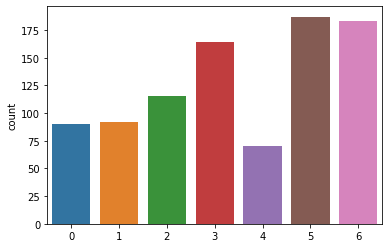

In [14]:
import seaborn as sns

sns.countplot(x=labels);

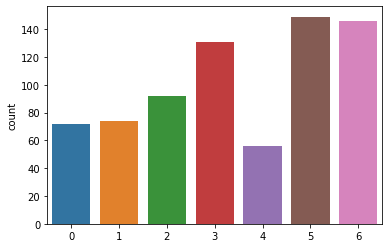

In [15]:
sns.countplot(x=trainY);

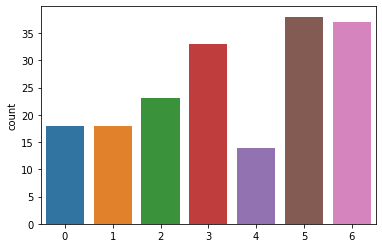

In [16]:
sns.countplot(x=testY);

In [18]:
def create_model(input_shape):

    model= Sequential()

    model.add(Conv2D(64,(3,3), padding='same', input_shape = input_shape))
    #model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, (3,3), padding='same'))
    #model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(256, (3,3), padding='same'))
    #model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dropout(0.5))

    model.add(Dense(len(CLASSES)))
    model.add(Activation('softmax'))
    
    return model

def create_vgg(input_shape):
    base_model = tf.keras.applications.VGG16(include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    return model

#model = create_model(data.shape[1:])
model = create_vgg(data.shape[1:])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, 
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, 
                         horizontal_flip=True, fill_mode="nearest")

model.summary()

58892288/58889256 [==============================] - 54s 1us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 3591      
Total params: 14,718,279
Trainable params: 3,591
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
EPOCHS = 20

H = model.fit(aug.flow(trainX, trainY, batch_size=32), 
             validation_data=(testX, testY), 
             steps_per_epoch=len(trainX) // 32,
             epochs=EPOCHS, verbose=1)


Epoch 1/20
22/22 [==============================] - 60s 3s/step - loss: 1.7531 - accuracy: 0.3198 - val_loss: 1.7447 - val_accuracy: 0.3094
Epoch 2/20
22/22 [==============================] - 60s 3s/step - loss: 1.7194 - accuracy: 0.3517 - val_loss: 1.7196 - val_accuracy: 0.3536
Epoch 3/20
22/22 [==============================] - 60s 3s/step - loss: 1.7089 - accuracy: 0.3634 - val_loss: 1.6994 - val_accuracy: 0.3425
Epoch 4/20
22/22 [==============================] - 60s 3s/step - loss: 1.6835 - accuracy: 0.3895 - val_loss: 1.6747 - val_accuracy: 0.3812
Epoch 5/20
22/22 [==============================] - 60s 3s/step - loss: 1.6576 - accuracy: 0.3881 - val_loss: 1.6584 - val_accuracy: 0.3646
Epoch 6/20
22/22 [==============================] - 62s 3s/step - loss: 1.6343 - accuracy: 0.3968 - val_loss: 1.6377 - val_accuracy: 0.3757
Epoch 7/20
22/22 [==============================] - 61s 3s/step - loss: 1.6317 - accuracy: 0.4012 - val_loss: 1.6244 - val_accuracy: 0.3812
Epoch 8/20
22/22 [==

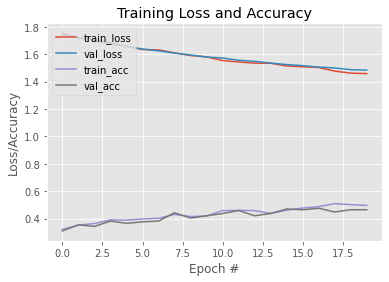

In [24]:
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left");

In [22]:
from sklearn.metrics import classification_report

preds = model.predict(testX)
predIdxs = np.argmax(preds, axis=1)

print(classification_report(testY, predIdxs, target_names=CLASSES.keys()))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        18
          10       0.00      0.00      0.00        23
          20       0.25      0.21      0.23        33
          50       0.00      0.00      0.00        14
         100       0.22      0.53      0.31        38
         200       0.37      0.59      0.45        37

    accuracy                           0.27       181
   macro avg       0.12      0.19      0.14       181
weighted avg       0.17      0.27      0.20       181

